In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np
import latentvelo as ltv

Global seed set to 0


In [2]:
adata = sc.read('../../../..//Pancreas/endocrinogenesis_day15.5.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [5]:
scv.pp.pca(adata)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.recover_dynamics(adata, n_jobs=12)
scv.tl.velocity(adata, mode='dynamical', vkey='dynvelo', n_jobs=12)
scv.tl.velocity(adata, mode='stochastic', vkey='stocvelo', n_jobs=12)

recovering dynamics (using 12/16 cores)


  0%|          | 0/1078 [00:00<?, ?gene/s]

    finished (0:01:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'dynvelo', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'stocvelo', velocity vectors for each individual cell (adata.layers)


In [7]:
scv.tl.velocity_graph(adata, vkey='dynvelo', n_jobs=12)
scv.tl.velocity_graph(adata, vkey='stocvelo', n_jobs=12)

computing velocity graph (using 12/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'dynvelo_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 12/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'stocvelo_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
cluster_edges = [
    ('Ngn3 low EP', 'Ngn3 high EP'), 
    ('Ngn3 high EP', 'Fev+'),
    ('Fev+', 'Delta'), 
    ('Fev+', 'Beta'), ('Fev+','Epsilon'), ('Fev+','Alpha')]

In [9]:
scv.tl.velocity_embedding(adata, vkey='dynvelo', basis='pca')
dyn_pca = ltv.ev.cross_boundary_correctness(adata,
                                  'clusters', 'dynvelo_pca', cluster_edges, x_emb='X_pca', 
                                   majority_vote=True, return_raw=True)

scv.tl.velocity_embedding(adata, vkey='stocvelo', basis='pca')
stoc_pca = ltv.ev.cross_boundary_correctness(adata,
                                  'clusters', 'stocvelo_pca', cluster_edges, x_emb='X_pca', 
                                   majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:00) --> added
    'dynvelo_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'stocvelo_pca', embedded velocity vectors (adata.obsm)


In [10]:
adata.obsm['X_pca_10'] = adata.obsm['X_pca'][:,:10]

scv.tl.velocity_embedding(adata, vkey='dynvelo', basis='pca_10')
dyn_pca_10 = ltv.ev.cross_boundary_correctness(adata,
                                  'clusters', 'dynvelo_pca_10', cluster_edges, x_emb='X_pca_10', 
                                   majority_vote=True, return_raw=True)

scv.tl.velocity_embedding(adata, vkey='stocvelo', basis='pca_10')
stoc_pca_10 = ltv.ev.cross_boundary_correctness(adata,
                                  'clusters', 'stocvelo_pca_10', cluster_edges, x_emb='X_pca_10', 
                                   majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:00) --> added
    'dynvelo_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'stocvelo_pca_10', embedded velocity vectors (adata.obsm)


In [11]:
dyn_pca_iccoh = ltv.ev.inner_cluster_coh(adata,
                                  'clusters', 'dynvelo_pca', return_raw=True, layer=False)
dyn_pca_10_iccoh = ltv.ev.inner_cluster_coh(adata,
                                  'clusters', 'dynvelo_pca_10', return_raw=True, layer=False)


stoc_pca_iccoh = ltv.ev.inner_cluster_coh(adata,
                                  'clusters', 'stocvelo_pca', return_raw=True, layer=False)
stoc_pca_10_iccoh = ltv.ev.inner_cluster_coh(adata,
                                  'clusters', 'stocvelo_pca_10', return_raw=True, layer=False)

In [12]:
np.save("fits/pancreas_dynvelo_pca.npy", dyn_pca)
np.save("fits/pancreas_dynvelo_pca_10.npy", dyn_pca_10)

np.save("fits/pancreas_stocvelo_pca.npy", stoc_pca)
np.save("fits/pancreas_stocvelo_pca_10.npy", stoc_pca_10)

np.save("fits/pancreas_dynvelo_iccoh_pca.npy", dyn_pca_iccoh)
np.save("fits/pancreas_dynvelo_iccoh_pca_10.npy", dyn_pca_10_iccoh)

np.save("fits/pancreas_stoc_iccoh_pca.npy", stoc_pca_iccoh)
np.save("fits/pancreas_stoc_iccoh_pca_10.npy", stoc_pca_10_iccoh)

computing velocity embedding
    finished (0:00:00) --> added
    'dynvelo_umap', embedded velocity vectors (adata.obsm)


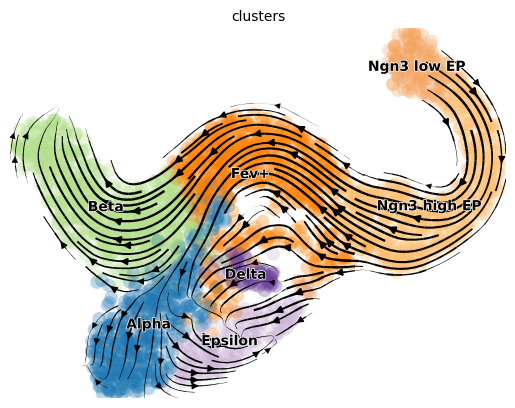

computing velocity embedding
    finished (0:00:00) --> added
    'stocvelo_umap', embedded velocity vectors (adata.obsm)


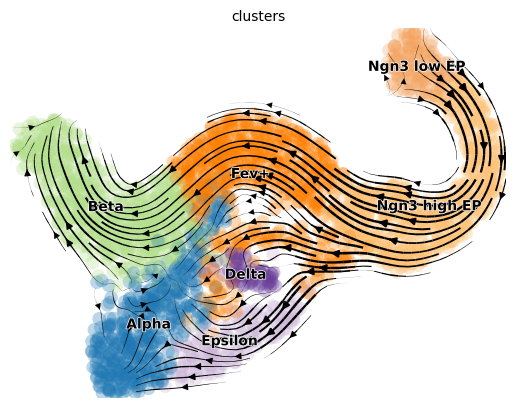

In [13]:
scv.pl.velocity_embedding_stream(adata, vkey='dynvelo', color=['clusters'], )
scv.pl.velocity_embedding_stream(adata, vkey='stocvelo', color=['clusters'])